## Imports 
Para realização do projeto foram escolhidas as seguintes bibliotecas, juntamente com elas estarão listadas as principais funcionalidades das mesmas nesse contexto:  
* Pandas - Processamento de dados e leitura do arquivo .csv
* Numpy - Operações envolvendo álgebra linear
* Matplotlib - Visualização de dados
* Nltk - Processamento de linguagem natural
* Sklearn - Mineração de dados e análise de dados
* Seaborn - Visualização de dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import nltk
import seaborn as sns

df_train = pd.read_csv('train.csv')

Analisando o cabeçalho do _data frame_

In [2]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Verificando a quantidade de tweets marcados como discurso de ódio ou não para decisão de métrica de avaliação.

In [3]:
print(str(len(df_train[df_train.label == 1])) + ' Hatred Tweets')
print(str(len(df_train[df_train.label == 0])) + ' Non-Hatred Tweets')

2242 Hatred Tweets
29720 Non-Hatred Tweets


Baseado no OutPut obtido da quantidade de tweets que contém discurso de ódio ou não, pode-se afimar que a métrica F1 score será a melhor para esse contexto, por

## Pre-processamento dos dados e EDA
O dataset apresenta uma série de menções a usuários e para não expor nenhum, os nomes foram substituídos por _"user"_. Logo, esse tipo de infomação deve ser descartada por não apresentar nenhum valor para a análise final.  
Já as hashtags presentes nos tweets serão movidas para outra coluna para futuro tratamento.  
Para ambos os tratamentos serão utilizadas expressões regulares para localização desses padrões de palavras.  
Além disso, essa etapa é crucial para identificação e escolha de features.

In [4]:

def remove_mentions(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = tweets.lower()
    return tweets

In [5]:
df_train['processed_text'] = df_train.tweet.apply(remove_mentions)

In [6]:
def extract_hashtags(df):
    hashtags = df['processed_text'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
    df.loc[:, 'hashtags'] = hashtags['hashtag']
    df['hashtags'].fillna('', inplace=True)
    return df

In [7]:
df_train = extract_hashtags(df_train)

Após o tratamento do data frame, retirando as menções e agrupando as hashtags em outra coluna, é necessário ainda filtrar caracteres que não se encaixam no padrão UTF-8. Além disso, caracteres especiais também são desnecessários para análise final, o que fazem deles descartáveis para o texto que servirá como base. Para finalizar, foi realizado o processo de lematização das palavras, que é deflexionar uma palavra para seu estado "base".
Foi usada a biblioteca **nltk** e **sklearn** para auxílio no processo de tratamento de palavras e caractéres.

In [8]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import re #expressões regulares em processamentos textuais
lemma = WordNetLemmatizer()

def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [10]:
df_train['processed_text'] = df_train.processed_text.apply(process_text)


**Data frame inicial após tratamento:**

In [11]:
df_train.head()

,id,label,tweet,processed_text,hashtags
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday majesty,
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,model
4,5,0,factsguide: society now #motivation,factsguide society motivation,motivation


### Visualização de palavras mais frequentes
Para melhor visualização das palavras que mais se repetem no dataset analisado, será implementado uma nuvem de palavras, utilizando a biblioteca wordcloud.

In [12]:
from wordcloud import WordCloud, STOPWORDS

In [13]:
all_words = ' '.join(df_train.processed_text)
hatred_words = ' '.join(df_train[df_train.label == 1].processed_text)

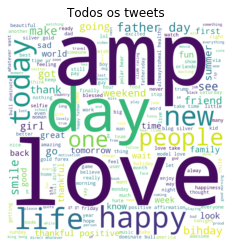

In [14]:
all_tweets_cloud = WordCloud(width=1000, height=1000, background_color='white', stopwords=STOPWORDS)
all_tweets_cloud = all_tweets_cloud.generate(all_words)
plt.imshow(all_tweets_cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Todos os tweets')
plt.show()

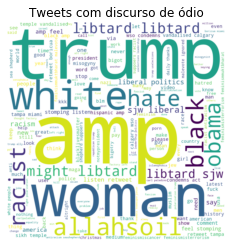

In [15]:
hatred_tweets_cloud = WordCloud(width=1000, height=1000, background_color='white', stopwords=STOPWORDS)
hatred_tweets_cloud = hatred_tweets_cloud.generate(hatred_words)
plt.imshow(hatred_tweets_cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Tweets com discurso de ódio')
plt.show()

### Visualização de hashtags mais frequentes
Para melhor visualização das hashtags que mais se repetem no dataset analisado, serão implementados gráficos, utilizando a biblioteca seaborn, biblioteca que usa como base a matplotlib.

In [16]:
from nltk import FreqDist 

all_hashtag_frequency = FreqDist(list((" ".join(df_train.hashtags)).split())).most_common(10)

hatred_hashtag_frequency = FreqDist(list((" ".join(df_train[df_train['label']==1]['hashtags'])).split())).most_common(10)


In [17]:
df_hatredhashtags = pd.DataFrame(hatred_hashtag_frequency, columns=['words', 'frequency'])
df_allhashtags = pd.DataFrame(all_hashtag_frequency, columns=['words', 'frequency'])

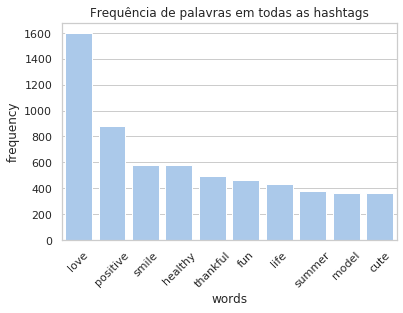

In [18]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x='words', y='frequency', data=df_allhashtags, color='b')
plt.xticks(rotation = 45)
plt.title('Frequência de palavras em todas as hashtags')
plt.show()

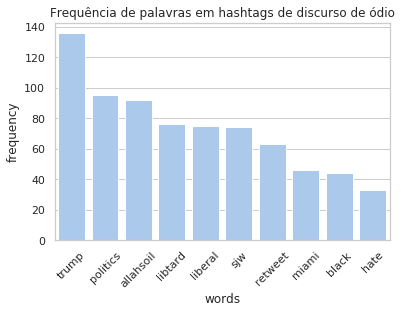

In [19]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x='words', y='frequency', data=df_hatredhashtags, color='b')
plt.xticks(rotation = 45)
plt.title('Frequência de palavras em hashtags de discurso de ódio')
plt.show()

## Escolha de features
A função **CountVectorizer** da biblioteca **sklearn** implementa tokenização e contagem de ocorrências de uma única classe, usa a abordagem **Bag of Words**, cada mensagem é separada por tokens e o números de vezes que um token aparece em cada mensagem é contado.  
**Tfidf vectorizer** calcula a frequencia inversa do termo e o valor da frequencia no documento para cada palavra. O **TF-IDF** é o produto de dois pesos, a frequência do termo (representa a frequência que um termo ocorre em um documento, se tivermos várias repetições do mesmo termo é esperado que o **TF-IDF** cresça) e a frequência inversa da frequencia no documento (representa a frequência que um termo ocorre no conjunto de documentos, se tivermos várias repetições do mesmo termo é esperado que o **TF-IDF** diminua). Assim, equilibrando o peso dos termos para cada corpo textual.  
Baseado no que foi observado de ambas funções e da EDA feita posteriormente a feature "processed_text", campo tratado proveniente do campo "tweet", é a melhor opção por existir a probabilidade do tweet não possuir hashtags. Foi utilizado da abordagem presente na **CountVectorizer** para inserir os dados no classificador.


In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score # performance evaluation criteria

count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = count_vectorizer.fit_transform(df_train['processed_text'])
X = count_vectorizer.transform(df_train.processed_text)

tfidf_transformer = TfidfTransformer(smooth_idf=False)
X_tfidf = tfidf_transformer.fit_transform(X)

Y = df_train.iloc[:,1].values

Separando o dataset em _training set_ e _test set_

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.33, random_state=42)

## Classificação e criação do modelo
### Regressão logística (Modelo linear)

In [22]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C=10)
classifier.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
Y_predict = classifier.predict(X_test)
Y_probability = classifier.predict_proba(X_test)

## Treinamento
Nessa etapa será utilizado o segundo dataset fornecido para testar o modelo implementado previamente.

In [24]:
df_test = pd.read_csv('test.csv')

In [25]:
df_test['processed_text'] = df_test.tweet.apply(process_text)
df_test.head()

,id,tweet,processed_text
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,user white supremacist want everyone see new b...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal acne altwaystoheal healthy healing
3,31966,is the hp and the cursed child book up for res...,hp cursed child book reservation already yes h...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",rd bihday amazing hilarious nephew eli ahmir u...


In [26]:
tokenize = count_vectorizer.fit_transform(df_train.processed_text)
tokenize = count_vectorizer.transform(df_test.processed_text)

In [27]:
tfidf_test = tfidf_transformer.fit_transform(tokenize)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [28]:
predict = classifier.predict(tfidf_test)
probability = classifier.predict_proba(tfidf_test)

In [29]:
df_test['predicted_label'] = predict
scores = (probability[:,1] >= 0.5).astype(int)
df_test['score'] = scores

In [30]:
df_test[df_test.predicted_label == 1]

,id,tweet,processed_text,predicted_label,score
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality right wing fasc...,1,1
26,31989,chick gets fucked hottest naked lady,chick get fucked hottest naked lady,1,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo taiji fisherman bullying racism tweet ta...,1,1
110,32073,hey @user - a $14000 ivanka bracelet? do you f...,hey user ivanka bracelet feel good profiting x...,1,1
140,32103,@user all together this christmas: pls &amp; ...,user together christmas pls amp follow user na...,1,1
...,...,...,...,...,...
17125,49088,be careful in criticizing #obama for his decis...,careful criticizing obama decision israel amp ...,1,1
17128,49091,@user the uk governmentâs new #anti-semitism...,user uk government new anti semitism definitio...,1,1
17176,49139,@user @user are the most racist pay ever!!!!!,user user racist pay ever,1,1
17188,49151,"black professor demonizes, proposes nazi style...",black professor demonizes proposes nazi style ...,1,1
